In [1]:
# All imports
import pdb
import os
from pickletools import optimize
from shutil import SpecialFileError
import time
import random
import argparse
import datetime
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import accuracy, AverageMeter

from config import get_config
from models import build_model
from data import build_loader
from lr_scheduler import build_scheduler
from optimizer import build_optimizer
from logger import create_logger
from utils import load_checkpoint, load_pretrained, save_checkpoint, get_grad_norm, auto_resume_helper, reduce_tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# Init args
def parse_option(config_path, output_path, tag):
    parser = argparse.ArgumentParser('Swin Transformer training and evaluation script', add_help=False)
    parser.add_argument('--cfg', type=str, metavar="FILE", help='path to config file', 
                        default=config_path)
    parser.add_argument(
        "--opts",
        help="Modify config options by adding 'KEY VALUE' pairs. ",
        default=None,
        nargs='+',
    )

    # easy config modification
    parser.add_argument('--batch-size', type=int, help="batch size for single GPU")
    parser.add_argument('--data-path', type=str, help='path to dataset', default=1)
    parser.add_argument('--zip', action='store_true', help='use zipped dataset instead of folder dataset')
    parser.add_argument('--cache-mode', type=str, default='part', choices=['no', 'full', 'part'],
                        help='no: no cache, '
                             'full: cache all data, '
                             'part: sharding the dataset into nonoverlapping pieces and only cache one piece')
    parser.add_argument('--pretrained',
                        help='pretrained weight from checkpoint, could be imagenet22k pretrained weight')
    parser.add_argument('--resume', help='resume from checkpoint')
    parser.add_argument('--accumulation-steps', type=int, help="gradient accumulation steps")
    parser.add_argument('--use-checkpoint', action='store_true',
                        help="whether to use gradient checkpointing to save memory")
    parser.add_argument('--amp-opt-level', type=str, default='O0', choices=['O0', 'O1', 'O2'],
                        help='mixed precision opt level, if O0, no amp is used')
    parser.add_argument('--output', default=output_path, type=str, metavar='PATH',
                        help='root of output folder, the full path is <output>/<model_name>/<tag> (default: output)')
    parser.add_argument('--tag', help='tag of experiment', default=tag)
    parser.add_argument('--eval', action='store_true', help='Perform evaluation only')
    parser.add_argument('--throughput', action='store_true', help='Test throughput only')
    parser.add_argument('--num_workers', default=8)
    parser.add_argument('--ffcv', action='store_true')
    parser.add_argument('--native_amp', action='store_true')

    # distributed training
    parser.add_argument(
        "--local_rank", type=int, help='local rank for DistributedDataParallel', default=0
    )

    args, unparsed = parser.parse_known_args()

    config = get_config(args)

    return args, config

def build_val_loader(config):
    from data.build import build_dataset
    from timm.data import Mixup
    config.defrost()
    dataset_train, config.MODEL.NUM_CLASSES = build_dataset(is_train=True, config=config)
    config.freeze()
    dataset_val, _ = build_dataset(is_train=False, config=config)

    

    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=config.DATA.BATCH_SIZE,
        shuffle=False,
        num_workers=config.DATA.NUM_WORKERS,
        pin_memory=config.DATA.PIN_MEMORY,
        drop_last=False
    )

    # setup mixup / cutmix
    mixup_fn = None
    mixup_active = config.AUG.MIXUP > 0 or config.AUG.CUTMIX > 0. or config.AUG.CUTMIX_MINMAX is not None
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=config.AUG.MIXUP, cutmix_alpha=config.AUG.CUTMIX, cutmix_minmax=config.AUG.CUTMIX_MINMAX,
            prob=config.AUG.MIXUP_PROB, switch_prob=config.AUG.MIXUP_SWITCH_PROB, mode=config.AUG.MIXUP_MODE,
            label_smoothing=config.MODEL.LABEL_SMOOTHING, num_classes=config.MODEL.NUM_CLASSES)

    return dataset_val, data_loader_val, mixup_fn

@torch.no_grad()
def validate(config, data_loader, model, accumulation_steps=1):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    for idx, (images, target) in enumerate(data_loader):
        formatted_images = images.cuda(non_blocking=True).unsqueeze(0)
        formatted_target = target.cuda(non_blocking=True).unsqueeze(0)
        
        A, B, C, H, W = formatted_images.shape
        A, B = formatted_target.shape
        if B // accumulation_steps == 0:
            zero_idx = 1
            ones_idx = B
        else:
            zero_idx = accumulation_steps
            ones_idx = B // accumulation_steps
        formatted_images = formatted_images.reshape(zero_idx, ones_idx, C, H, W)
        formatted_target = formatted_target.reshape(zero_idx, ones_idx)
        
        for accumulation_step in range(accumulation_steps):
            images = formatted_images[accumulation_step]
            target = formatted_target[accumulation_step]
        
            # compute output
            output = model(images, use_amp=False)

            # measure accuracy and record loss
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

    #         acc1 = acc1
    #         acc5 = reduce_tensor(acc5)
    #         loss = reduce_tensor(loss)

            loss_meter.update(loss.item(), target.size(0))
            acc1_meter.update(acc1.item(), target.size(0))
            acc5_meter.update(acc5.item(), target.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if idx % config.PRINT_FREQ == 0:
                memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
                print(
                    f'Test: [{idx}/{len(data_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                    f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'
                    f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'
                    f'Mem {memory_used:.0f}MB')
            images = images.cpu()
            target = target.cpu()
    print(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg

In [3]:
id2label = {}
with open('/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python/id2label.txt', 'r') as handle:
    for idx, line in enumerate(handle):
        if idx % 2 == 0:
            element, label = line.strip().split(': ')
            id2label[int(element)] = label

In [4]:
our_output_path = '/srv/share4/gstoica3/checkpoints/bestBiSABaseCifar'
config_file = 'biswin_tiny_patch4_window7_224_cifar100.yaml'
our_config_path = f'configs/{config_file}'
os.listdir(os.path.join(our_output_path))

['NoNorm.5LambdaNoBias']

In [5]:
our_tag = 'NoNorm.5LambdaNoBias'
_, our_config = parse_option(our_config_path, our_output_path, our_tag)

=> merge config from configs/biswin_tiny_patch4_window7_224_cifar100.yaml


In [6]:
csam_seed = our_config.SEED
torch.manual_seed(csam_seed)
torch.cuda.manual_seed(csam_seed)
np.random.seed(csam_seed)
random.seed(csam_seed)
cudnn.benchmark = True

In [7]:
our_config.defrost()
our_config.TRAIN.BASE_LR = .000001
our_config.TRAIN.WARMUP_LR = .000001
our_config.TRAIN.MIN_LR = .000001
our_config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
our_config.freeze()

In [8]:
our_dataset_val, our_data_loader_val, our_mixup_fn = build_val_loader(our_config)

Files already downloaded and verified
Files already downloaded and verified


/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
our_model = build_model(our_config)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [27]:
our_model.cuda()
# our_resume_file = auto_resume_helper(our_config.OUTPUT)
our_resume_file = '/srv/share4/gstoica3/checkpoints/bestBiSABaseCifar/NoNorm.5LambdaNoBias/ckpt_epoch_507.pth'
our_config.defrost()
our_config.MODEL.PRETRAINED = our_resume_file
our_config.freeze()

checkpoint = torch.load(our_config.MODEL.PRETRAINED, map_location='cpu')
# pdb.set_trace()
msg = our_model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

# load_pretrained(our_config, our_model)

<All keys matched successfully>


In [28]:
from fvcore.nn import FlopCountAnalysis

In [30]:
for idx, (images, target) in enumerate(our_data_loader_val):
    images = images[:20].cuda(non_blocking=True)
    target = target[:20].cuda(non_blocking=True)
    break

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [36]:
flops = FlopCountAnalysis(our_model, images[0, None])

In [37]:
flops.total()

/nethome/gstoica3/research/Swin-Transformer/models/reversed_swin_transformer.py:48: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
/nethome/gstoica3/research/Swin-Transformer/models/reversed_swin_transformer.py:296: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor')

5289442560

In [ ]:
5,289,442,560

In [38]:
our_acc1, our_acc5, our_loss = validate(our_config, our_data_loader_val, our_model, accumulation_steps=2)

Test: [0/79]	Time 2.754 (2.754)	Loss 0.8389 (0.8389)	Acc@1 81.250 (81.250)	Acc@5 96.875 (96.875)	Mem 4017MB
Test: [0/79]	Time 0.203 (1.478)	Loss 0.9334 (0.8862)	Acc@1 79.688 (80.469)	Acc@5 96.875 (96.875)	Mem 4017MB
Test: [10/79]	Time 0.197 (0.310)	Loss 1.1357 (1.0325)	Acc@1 73.438 (78.274)	Acc@5 90.625 (94.420)	Mem 4017MB
Test: [10/79]	Time 0.182 (0.304)	Loss 1.0415 (1.0329)	Acc@1 76.562 (78.196)	Acc@5 96.875 (94.531)	Mem 4017MB
Test: [20/79]	Time 0.195 (0.250)	Loss 1.1688 (1.0205)	Acc@1 78.125 (79.040)	Acc@5 95.312 (94.169)	Mem 4017MB
Test: [20/79]	Time 0.181 (0.248)	Loss 0.9885 (1.0197)	Acc@1 79.688 (79.055)	Acc@5 98.438 (94.271)	Mem 4017MB
Test: [30/79]	Time 0.188 (0.229)	Loss 1.1235 (1.0219)	Acc@1 73.438 (78.765)	Acc@5 93.750 (94.185)	Mem 4017MB
Test: [30/79]	Time 0.183 (0.228)	Loss 0.7896 (1.0181)	Acc@1 81.250 (78.805)	Acc@5 96.875 (94.229)	Mem 4017MB
Test: [40/79]	Time 0.189 (0.218)	Loss 0.8721 (1.0107)	Acc@1 84.375 (79.090)	Acc@5 95.312 (94.174)	Mem 4017MB
Test: [40/79]	Time 0.

In [24]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def get_magnitudes(self, x, mask=None):
    magnitudes = {}
    # pdb.set_trace()
    BW, K2, C = x.shape
    qk = self.qk(x).reshape(BW, K2, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k = qk[0], qk[1]  # make torchscript happy (cannot use tensor as tuple)
    q = q * self.scale
    attn = (q @ k.transpose(-2, -1))

    relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
        self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
    relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
    attn = attn + relative_position_bias.unsqueeze(0)

    if mask is not None:
        nW = mask.shape[0]
        attn = attn.view(BW // nW, nW, self.num_heads, K2, K2) + mask.unsqueeze(1).unsqueeze(0)
        attn = attn.view(-1, self.num_heads, K2, K2)
        reverse_attn = F.softmax(attn, -2)
        attn = self.softmax(attn)
    else:
        attn = self.softmax(attn)
        reverse_attn = F.softmax(attn, -2)

    attn = self.attn_drop(attn) # [BW, h, K2, K2]

    forward_attn = self.apply_forward_attention(x, attn)
    reverse_attn = self.apply_reverse_attention(x, reverse_attn)
    
    magnitudes['SA'] = forward_attn.norm(dim=-1).mean().detach().cpu().numpy()
    magnitudes['ISA'] = reverse_attn.norm(dim=-1).mean().detach().cpu().numpy()

    return magnitudes


def get_reverse_magnitudes(self, x, mask=None):
    magnitudes = {}
    BW, K2, C = x.shape
    qk = self.reverse_qk(x).reshape(BW, K2, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k = qk[0], qk[1]  # make torchscript happy (cannot use tensor as tuple)
    v = self.reverse_v(x).reshape(BW, K2, self.num_heads, C // self.num_heads).transpose(2, 1)
    q = q * self.scale
    attn = (q @ k.transpose(-2, -1))

    relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
        self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
    relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
    attn = attn + relative_position_bias.unsqueeze(0)

    if mask is not None:
        nW = mask.shape[0]
        attn = attn.view(BW // nW, nW, self.num_heads, K2, K2) + mask.unsqueeze(1).unsqueeze(0)
        attn = attn.view(-1, self.num_heads, K2, K2)
        attn = self.softmax(attn)
    else:
        attn = self.softmax(attn)

    attn = self.reverse_attn_drop(attn).transpose(-2, -1) # [BW, h, K2, K2]
    if self.mechanism_instructions.get('transpose_softmax', True):
        attn = attn.transpose(-2, -1)

    v = self.reverse_activation(v)
    expert_mixture = (attn @ v) # [BW, h, K2, C/h]
    # pdb.set_trace()
    if self.reduce_reverse:
        if self.mechanism_instructions.get('project_input', True):
            v_r = self.reverse_reducer(x)
        else:
            v_r = x
        v_r = self.reverse_activation(v_r)
        v_r = v_r.reshape(BW, K2, self.num_heads, self.embed_dim, 1).transpose(2, 1)
        weights = self.weight_generator(expert_mixture).reshape(BW, self.num_heads, K2, self.embed_dim, self.embed_dim)

        output = (weights @ v_r).squeeze(-1)
        
        magnitudes['weights'] = output.transpose(2,1).flatten(2).norm(dim=-1).mean()
        if self.hypernetwork_bias:
            biases = self.bias_generator(expert_mixture)
#             pdb.set_trace()
            magnitudes['biases'] = biases.transpose(2,1).flatten(2).norm(dim=-1).mean()
        
    return magnitudes


In [25]:
def get_bisa_magnitudes(our_model, data_loader, on_second_window=False):
    attention_layer = our_model.layers[0]
    self = attention_layer.blocks[0]
    model = our_model

    isa_magnitudes = []
    sa_magnitudes = []

    for idx, (images, target) in tqdm(enumerate(data_loader)):
        formatted_images = images.cuda(non_blocking=True)
        formatted_target = target.cuda(non_blocking=True)

        patched_images = model.patch_embed(formatted_images)
        if model.ape:
            patched_images += model.absolute_pos_embed
        x = model.pos_drop(patched_images)
        
        if on_second_window:
            x = attention_layer.blocks[0](x)
            self = attention_layer.blocks[1]
        
        H, W = self.input_resolution
        B, L, C = x.shape
        try:
            assert L == H * W, "input feature has wrong size"
        except:
            pdb.set_trace()

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        magnitudes = get_magnitudes(self.attn, x_windows)
        isa_magnitudes.append(magnitudes['SA'].tolist())
        sa_magnitudes.append(magnitudes['ISA'].tolist())
    return np.array(isa_magnitudes), np.array(sa_magnitudes)



In [45]:
isa_magnitudes, sa_magnitudes = get_bisa_magnitudes(our_model, our_data_loader_val, False)

79it [00:07, 10.32it/s]


In [46]:
isa_magnitudes.mean(), sa_magnitudes.mean()

(5.411245195171501, 4.874295820163775)

In [13]:
isa_magnitudes, sa_magnitudes = get_bisa_magnitudes(our_model, our_data_loader_val, True)
isa_magnitudes.mean(), sa_magnitudes.mean()

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:01, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 10.76 GiB total capacity; 9.05 GiB already allocated; 78.56 MiB free; 9.06 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### Magnitudes for weights and biases are similar. For shortcut the weight is very low.

## All Layers Frozen Except for Ours

In [9]:
for idx, (images, target) in enumerate(our_data_loader_val):
    images = images[:20].cuda(non_blocking=True)
    target = target[:20].cuda(non_blocking=True)
    break

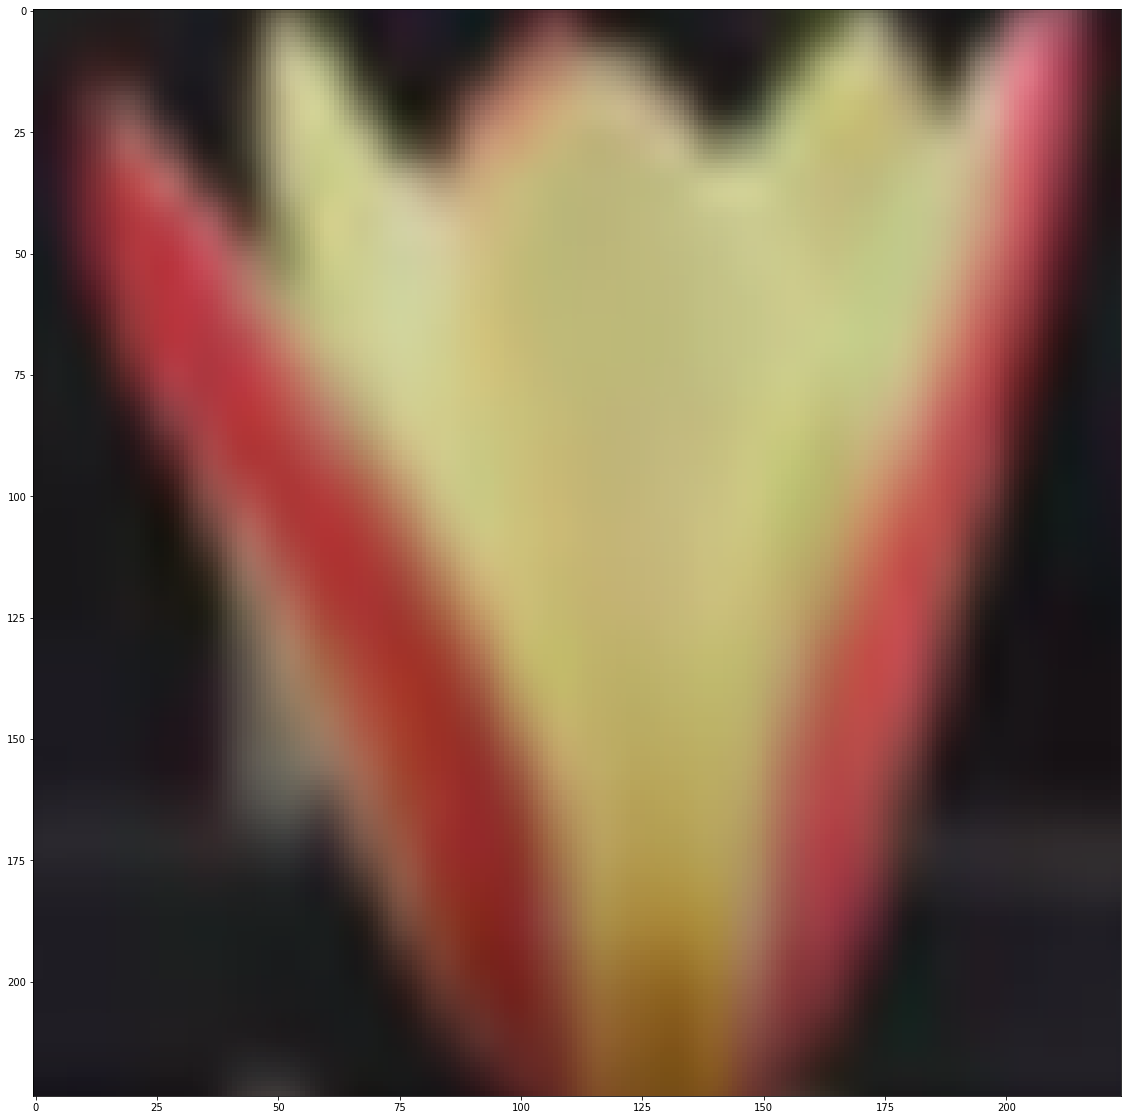

In [23]:
MEAN = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
STD = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
plt. figure(figsize=(20, 20))
plt.imshow(np.transpose((images[16].detach().cpu().numpy() * STD) + MEAN, (1,2,0)))

In [17]:
our_model.cuda()
# our_resume_file = auto_resume_helper(our_config.OUTPUT)
our_resume_file = '/srv/share4/gstoica3/checkpoints/biswin_reverseBase_cifar/biswin_tiny_patch4_window7_224_cifar100/reduce_gelu_finetuneFreezeBase/ckpt_epoch_139.pth'
our_config.defrost()
our_config.MODEL.PRETRAINED = our_resume_file
our_config.freeze()
load_pretrained(our_config, our_model)

In [18]:
our_acc1, our_acc5, our_loss = validate(our_config, our_data_loader_val, our_model, accumulation_steps=2)

Test: [0/79]	Time 1.501 (1.501)	Loss 0.8494 (0.8494)	Acc@1 78.125 (78.125)	Acc@5 95.312 (95.312)	Mem 31695MB
Test: [0/79]	Time 0.156 (0.828)	Loss 0.9147 (0.8821)	Acc@1 81.250 (79.688)	Acc@5 96.875 (96.094)	Mem 31695MB
Test: [10/79]	Time 0.120 (0.186)	Loss 1.0886 (1.0247)	Acc@1 70.312 (77.158)	Acc@5 93.750 (94.345)	Mem 31695MB
Test: [10/79]	Time 0.115 (0.183)	Loss 1.0642 (1.0265)	Acc@1 73.438 (76.989)	Acc@5 92.188 (94.247)	Mem 31695MB
Test: [20/79]	Time 0.118 (0.153)	Loss 1.1017 (1.0254)	Acc@1 78.125 (77.553)	Acc@5 92.188 (93.826)	Mem 31695MB
Test: [20/79]	Time 0.116 (0.152)	Loss 0.9668 (1.0240)	Acc@1 78.125 (77.567)	Acc@5 95.312 (93.862)	Mem 31695MB
Test: [30/79]	Time 0.117 (0.142)	Loss 1.0970 (1.0261)	Acc@1 75.000 (76.895)	Acc@5 96.875 (93.929)	Mem 31695MB
Test: [30/79]	Time 0.116 (0.141)	Loss 0.7861 (1.0222)	Acc@1 81.250 (76.966)	Acc@5 98.438 (94.002)	Mem 31695MB
Test: [40/79]	Time 0.118 (0.136)	Loss 0.9066 (1.0176)	Acc@1 84.375 (77.218)	Acc@5 96.875 (94.232)	Mem 31695MB
Test: [40/79

In [19]:
magnitudes_w, magnitudes_b, magnitudes_x = get_reverse_weights_bias_magnitudes(our_model, our_data_loader_val, False)
magnitudes_w.mean(), magnitudes_b.mean(), magnitudes_x.mean()

79it [00:05, 15.17it/s]


(5.492788574363612, 1.055883535855933, 1.7130975310952475e-09)

In [20]:
second_magnitudes_w, second_magnitudes_b, second_magnitudes_x = get_reverse_weights_bias_magnitudes(
    our_model, our_data_loader_val, True
)
second_magnitudes_w.mean(), second_magnitudes_b.mean(), second_magnitudes_x.mean()

79it [00:09,  8.15it/s]


(3.022934874401817, 0.6016545982300481, 1.2087719083411246e-09)

#### Slightly better performance when running finetuning on just our layers. Interestingly, though we see the magnitude from the weight projection trounces that of the bias...

In [15]:
our_model.cuda()
# our_resume_file = auto_resume_helper(our_config.OUTPUT)
our_resume_file = '/srv/share4/gstoica3/checkpoints/biswin_reverseBase_cifar/biswin_tiny_patch4_window7_224_cifar100/reduce_gelu/ckpt_epoch_582.pth'
our_config.defrost()
our_config.MODEL.PRETRAINED = our_resume_file
our_config.freeze()
load_pretrained(our_config, our_model)

In [16]:
our_acc1, our_acc5, our_loss = validate(our_config, our_data_loader_val, our_model, accumulation_steps=2)

Test: [0/79]	Time 2.218 (2.218)	Loss 0.7782 (0.7782)	Acc@1 82.812 (82.812)	Acc@5 96.875 (96.875)	Mem 3682MB
Test: [0/79]	Time 0.161 (1.189)	Loss 0.7151 (0.7467)	Acc@1 87.500 (85.156)	Acc@5 98.438 (97.656)	Mem 3682MB
Test: [10/79]	Time 0.117 (0.227)	Loss 0.9791 (0.8867)	Acc@1 81.250 (81.994)	Acc@5 92.188 (95.610)	Mem 3682MB
Test: [10/79]	Time 0.116 (0.222)	Loss 0.9711 (0.8906)	Acc@1 82.812 (82.031)	Acc@5 95.312 (95.597)	Mem 3682MB
Test: [20/79]	Time 0.119 (0.174)	Loss 0.9900 (0.8811)	Acc@1 81.250 (82.203)	Acc@5 93.750 (95.541)	Mem 3682MB
Test: [20/79]	Time 0.116 (0.172)	Loss 0.9328 (0.8823)	Acc@1 85.938 (82.292)	Acc@5 96.875 (95.573)	Mem 3682MB
Test: [30/79]	Time 0.120 (0.155)	Loss 1.0820 (0.8990)	Acc@1 71.875 (81.609)	Acc@5 96.875 (95.287)	Mem 3682MB
Test: [30/79]	Time 0.116 (0.154)	Loss 0.6584 (0.8951)	Acc@1 85.938 (81.678)	Acc@5 96.875 (95.312)	Mem 3682MB
Test: [40/79]	Time 0.120 (0.146)	Loss 0.8529 (0.8936)	Acc@1 79.688 (81.462)	Acc@5 95.312 (95.390)	Mem 3682MB
Test: [40/79]	Time 0.

In [19]:
magnitudes_w, magnitudes_b, magnitudes_x = get_reverse_weights_bias_magnitudes(our_model, our_data_loader_val, False)
magnitudes_w.mean(), magnitudes_b.mean(), magnitudes_x.mean()

79it [00:04, 16.08it/s]


(4.054132660732994, 1.8991642179368418, 9.208199276039061e-10)

In [20]:
second_magnitudes_w, second_magnitudes_b, second_magnitudes_x = get_reverse_weights_bias_magnitudes(
    our_model, our_data_loader_val, True
)
second_magnitudes_w.mean(), second_magnitudes_b.mean(), second_magnitudes_x.mean()

79it [00:09,  8.40it/s]


(2.5887911712067035, 1.7231623447394069, 1.0830434221746112e-09)